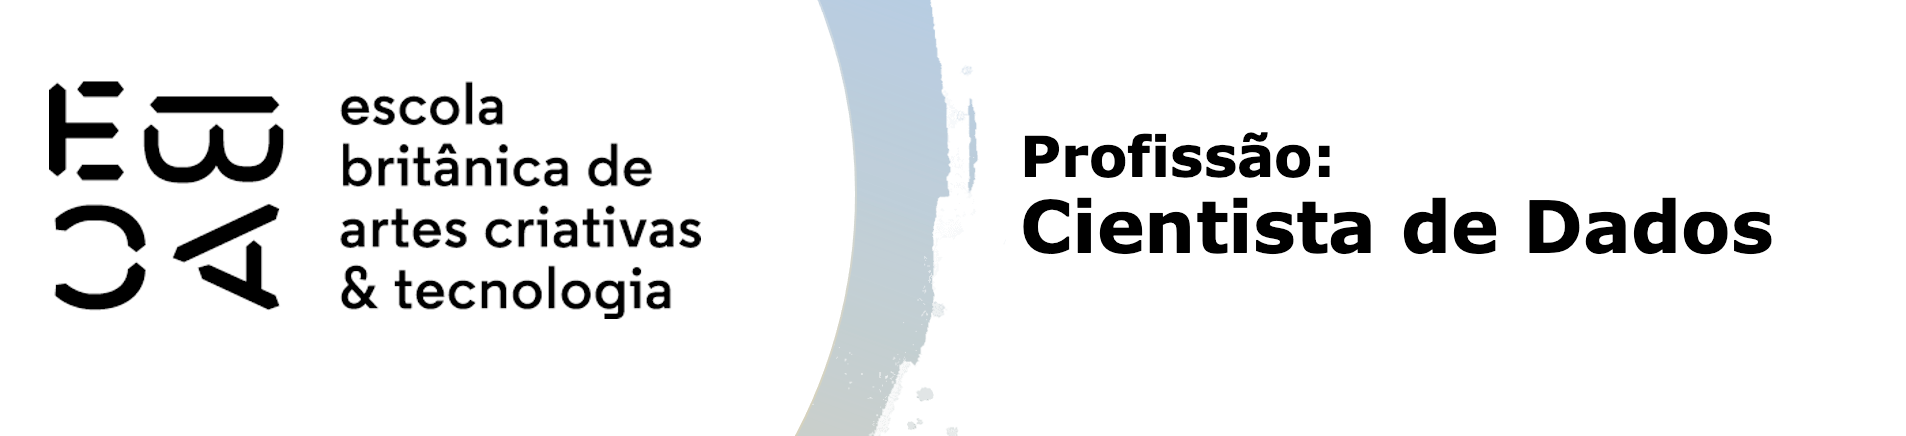

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [109]:
import pandas as pd
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from scipy.stats import ks_2samp

In [38]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [26]:
df['ano'] = df['data_ref'].dt.year
df['mes'] = df['data_ref'].dt.month
df['mes_ano'] = df['data_ref'].dt.strftime('%m-%Y')

df_modelo = df[df['ano']==2015]
df_oot = df[df['ano']==2016]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [31]:
df.groupby(['mes'])['mes'].count()

mes
1     100000
2     100000
3     100000
4      50000
5      50000
6      50000
7      50000
8      50000
9      50000
10     50000
11     50000
12     50000
Name: mes, dtype: int64

In [32]:
df.describe()

,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,ano,mes
count,750000.000000,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05,750000.0,750000.000000
mean,8319.272793,0.433251,43.804733,7.748574,2.212241,2.323854e+04,2015.2,5.600000
std,4809.281774,0.739379,11.229868,6.687455,0.903428,7.910601e+04,0.4,3.592587
min,0.000000,0.000000,22.000000,0.117808,1.000000,1.076700e+02,2015.0,1.000000
25%,4147.000000,0.000000,34.000000,3.049315,2.000000,3.467700e+03,2015.0,2.000000
50%,8324.000000,0.000000,43.000000,6.046575,2.000000,7.861820e+03,2015.0,5.000000
75%,12487.000000,1.000000,53.000000,10.183562,3.000000,1.831828e+04,2015.0,9.000000
max,16649.000000,14.000000,68.000000,42.906849,15.000000,4.083986e+06,2016.0,12.000000


In [36]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]
 
    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [42]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados['poder_preditivo'] = '-'

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

metadados.loc['mau','IV'] = '-'
        
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'IV']<0.02):
        metadados.loc[var, 'poder_preditivo'] = 'Inútil'
    elif (metadados.loc[var, 'IV']<0.1):
        metadados.loc[var, 'poder_preditivo'] = 'Fraco'
    elif (metadados.loc[var, 'IV']<0.3):
        metadados.loc[var, 'poder_preditivo'] = 'Médio'
    elif (metadados.loc[var, 'IV']<0.5):
        metadados.loc[var, 'poder_preditivo'] = 'Forte'
    else: 
        metadados.loc[var, 'poder_preditivo'] = 'Suspeito'
        
metadados

,dtype,nmissing,valores_unicos,papel,poder_preditivo,IV
data_ref,datetime64[ns],0,15,covariavel,Forte,0.345982
index,int64,0,16650,covariavel,Inútil,0.002664
sexo,object,0,2,covariavel,Inútil,0.002185
posse_de_veiculo,object,0,2,covariavel,Inútil,0.000108
posse_de_imovel,object,0,2,covariavel,Inútil,0.009693
qtd_filhos,int64,0,8,covariavel,Inútil,0.00003
tipo_renda,object,0,5,covariavel,Inútil,0.00936
educacao,object,0,5,covariavel,Inútil,0.003547
estado_civil,object,0,5,covariavel,Inútil,0.001126
tipo_residencia,object,0,6,covariavel,Inútil,0.003045


A partir da análise acima, pelo critério do IV apenas 'tempo_emprego' se mostra uma variável útil.

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [45]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

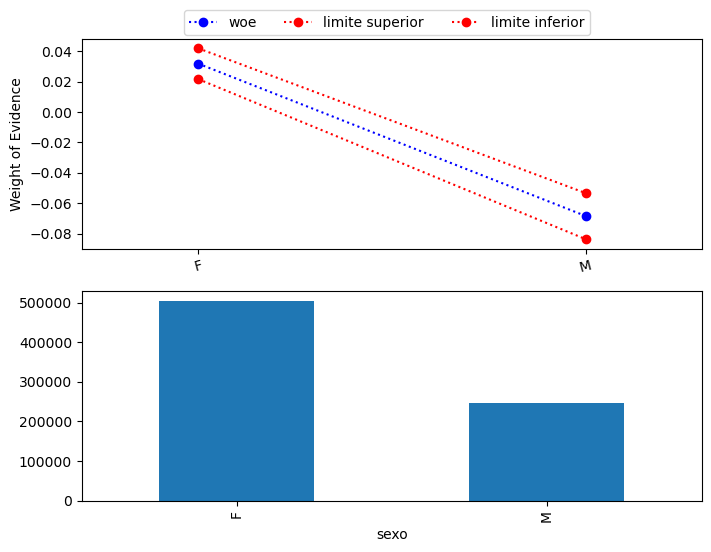

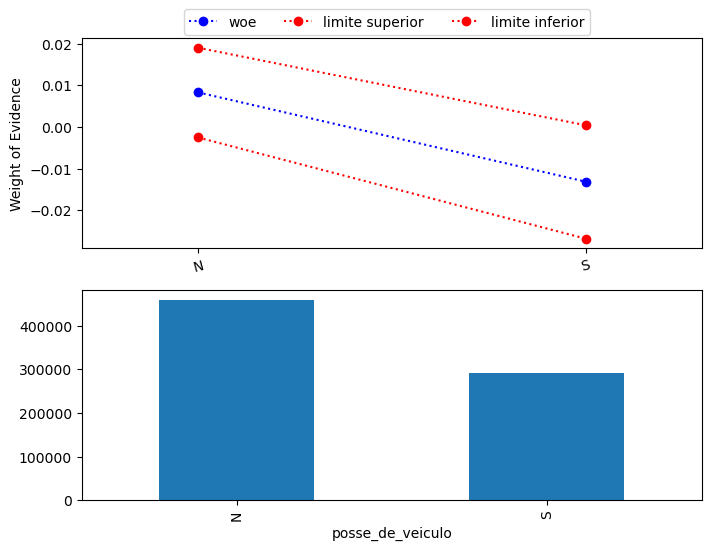

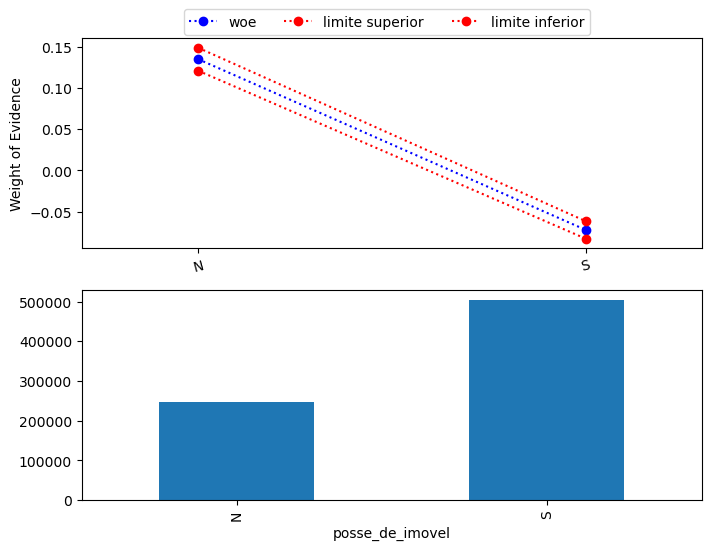

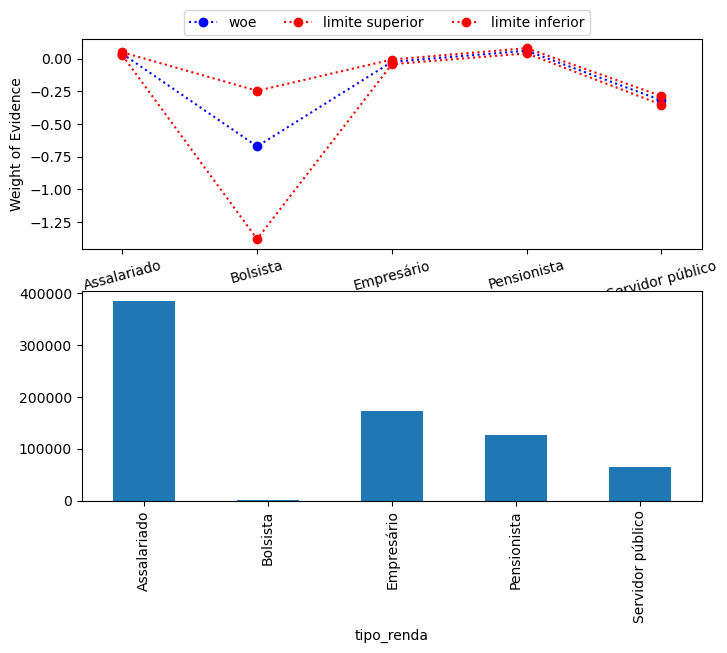

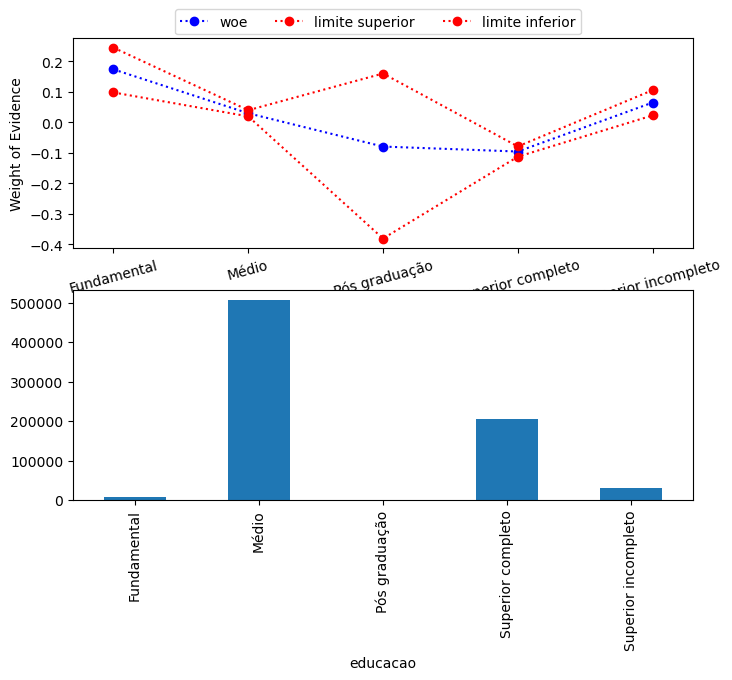

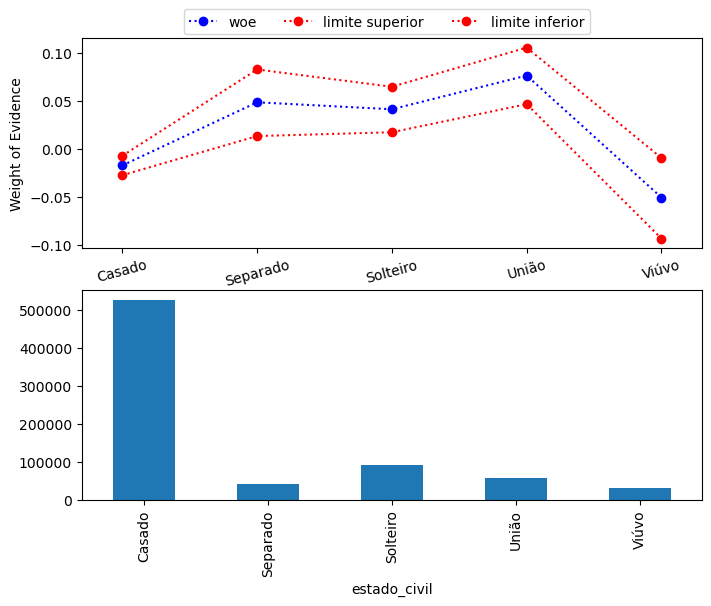

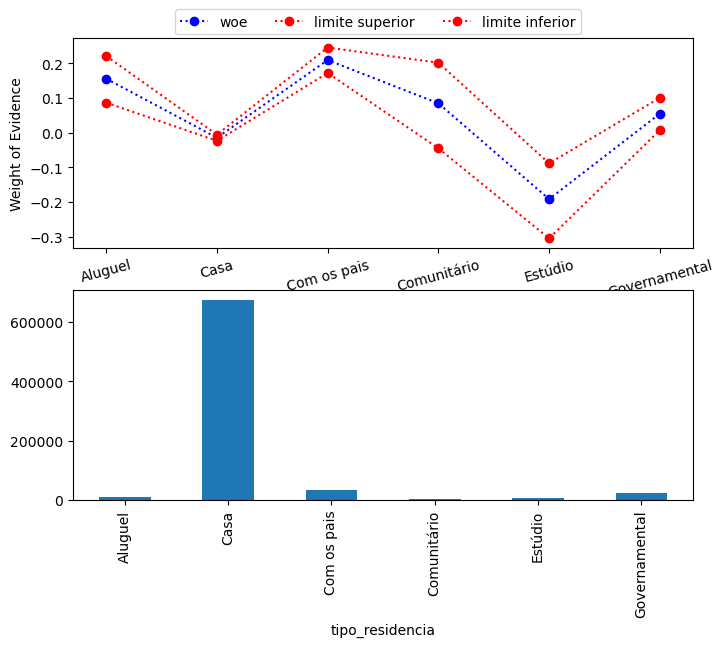

In [50]:
for var in metadados[metadados.dtype=='object'].index:
    biv_discreta(var,df);

In [56]:

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

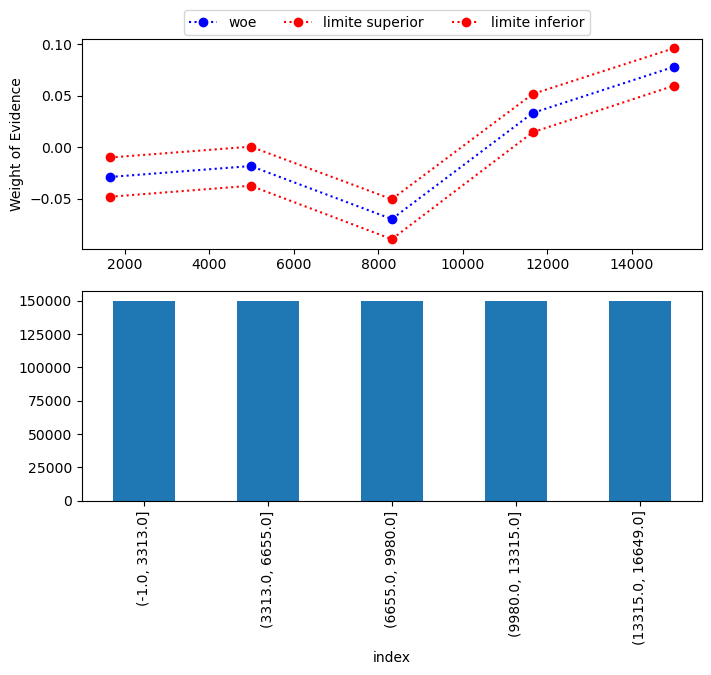

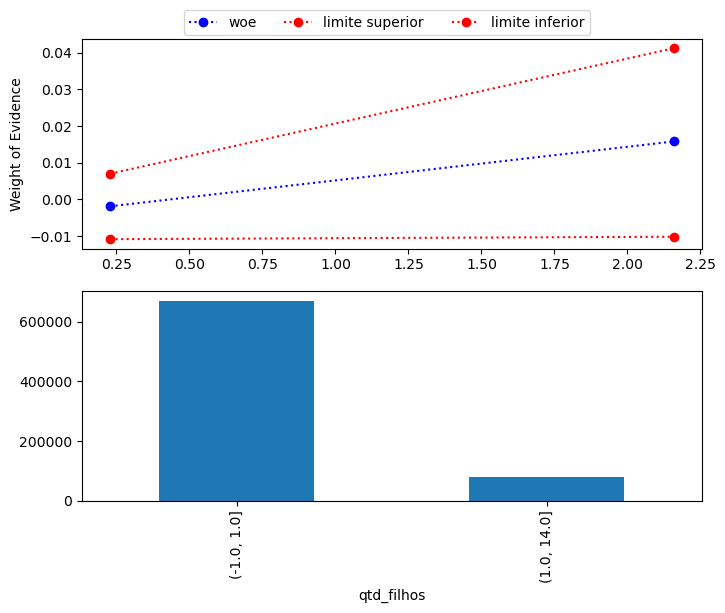

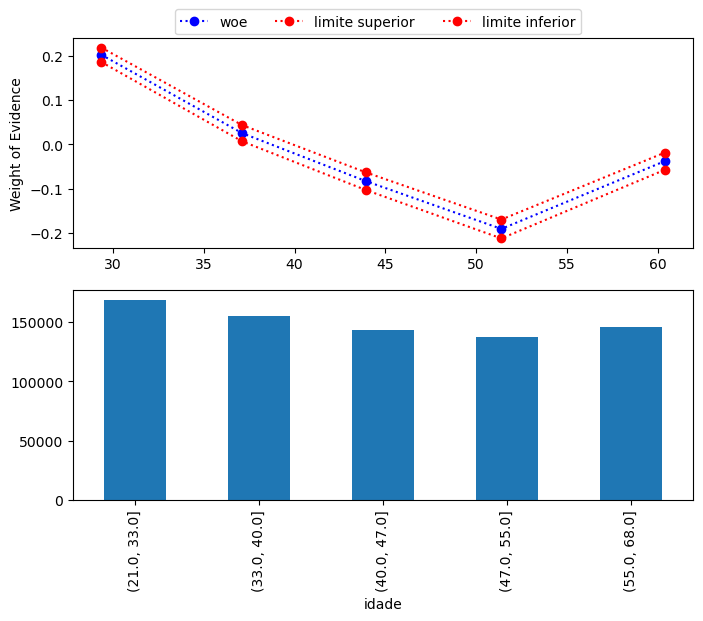

In [72]:
for var in metadados[metadados.dtype=='int64'].index:
    if (metadados.loc[var,'valores_unicos']>5):
        biv_continua(var,5,df);
    else:
        biv_continua(var,metadados.loc[var,'valores_unicos'],df);

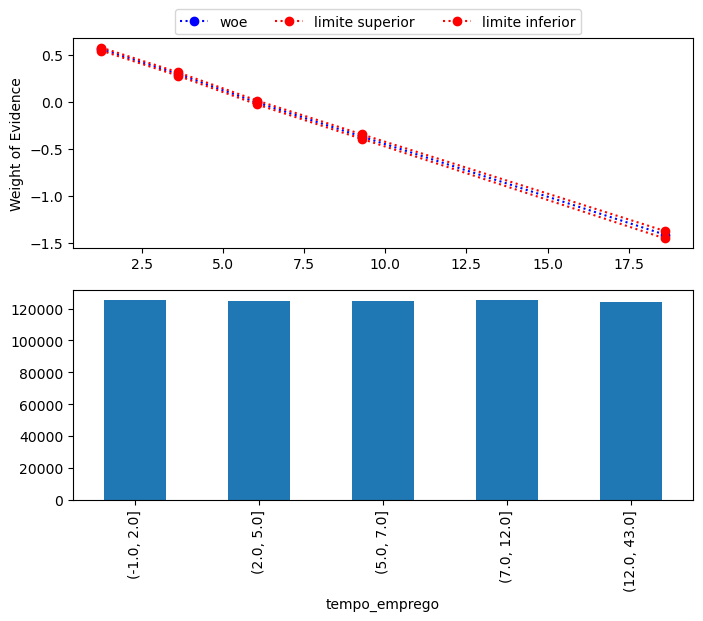

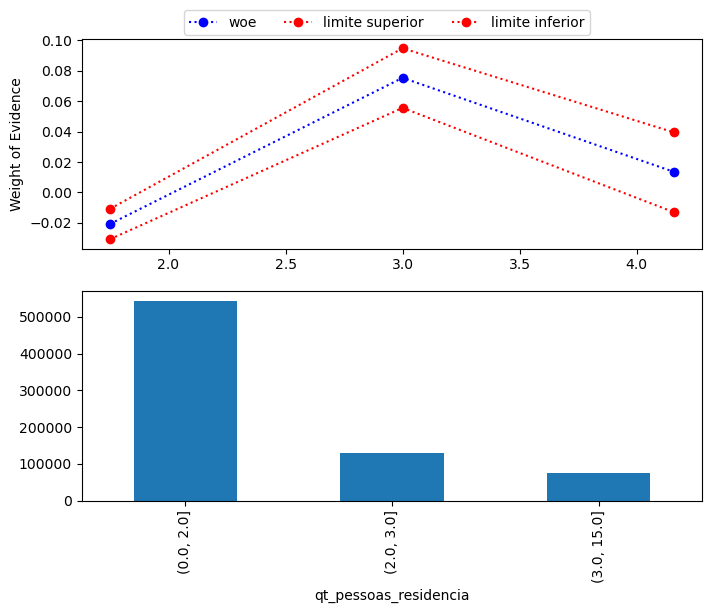

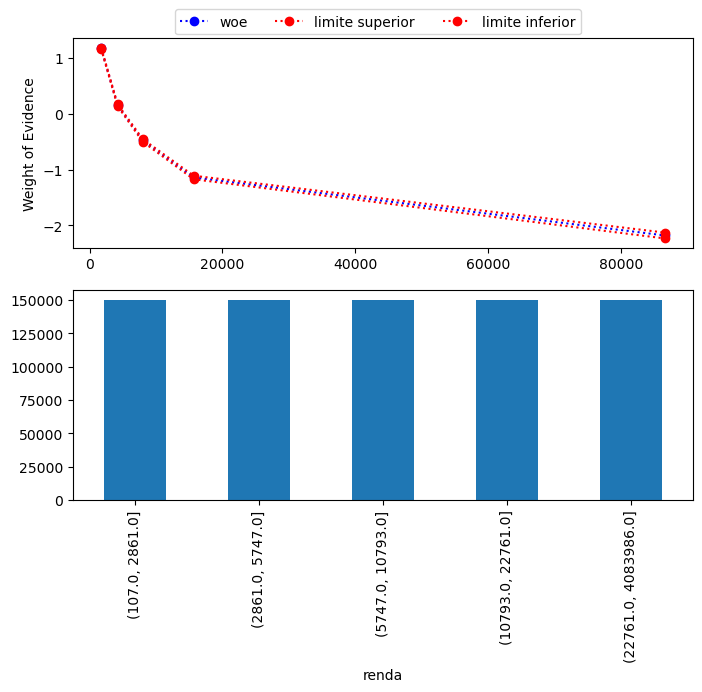

In [73]:
for var in metadados[metadados.dtype=='float64'].index:
    if (metadados.loc[var,'valores_unicos']>5):
        biv_continua(var,5,df);
    else:
        biv_continua(var,metadados.loc[var,'valores_unicos'],df);

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais': **NÃO HÁ**
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [77]:
df.fillna(df.tempo_emprego.mean(), inplace=True)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,7789,786,0.091662,Fundamental,8575,0.003116,0.097770,0.085554,-2.293511,-2.222252,-2.369175,0.173677,0.244936,0.098013
Graduação/Pós,190437,14681,0.071573,Graduação/Pós,205118,0.000569,0.072689,0.070458,-2.562767,-2.546099,-2.579677,-0.095579,-0.078911,-0.112489
Médio,466106,40730,0.080361,Médio,506836,0.000382,0.081110,0.079613,-2.437448,-2.427364,-2.447619,0.029740,0.039824,0.019570
Superior incompleto,27025,2446,0.082997,Superior incompleto,29471,0.001607,0.086147,0.079847,-2.402308,-2.361619,-2.444427,0.064880,0.105569,0.022761


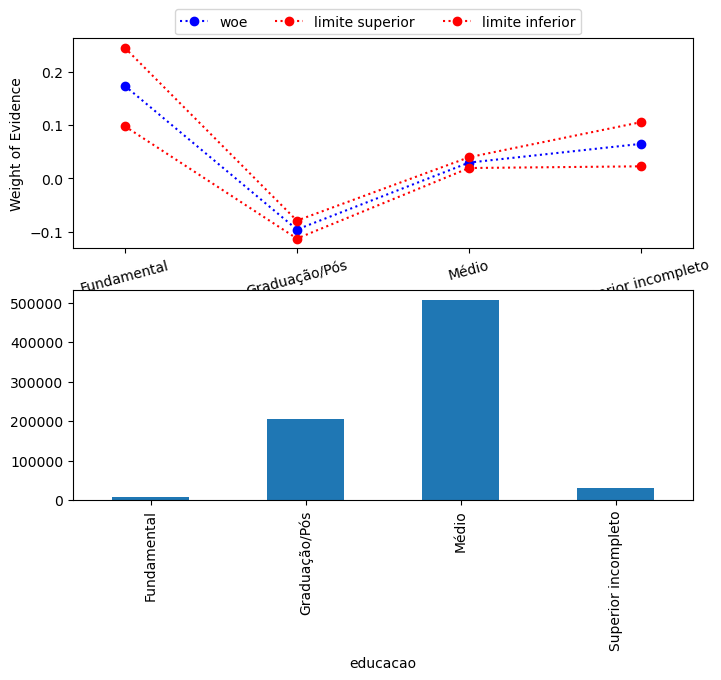

In [81]:
df.educacao.replace({'Pós graduação':'Graduação/Pós', 
                      'Superior completo':'Graduação/Pós'}, inplace=True)
biv_discreta('educacao', df)

In [91]:
' + '.join(list(metadados[metadados.index!='mau'].sort_values(by='IV', ascending=False).index))

'renda + tempo_emprego + data_ref + idade + posse_de_imovel + tipo_renda + educacao + tipo_residencia + index + sexo + qt_pessoas_residencia + estado_civil + posse_de_veiculo + qtd_filhos'

In [93]:
formula = '''
    mau ~ renda + tempo_emprego + idade + posse_de_imovel + tipo_renda + educacao + tipo_residencia + 
          sexo + qt_pessoas_residencia + estado_civil + posse_de_veiculo + qtd_filhos
'''

rl = smf.glm(formula, data=df, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               750000
Model:                                     GLM   Df Residuals:                   749975
Model Family:                         Binomial   Df Model:                           24
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.8357e+05
Date:                         Thu, 27 Apr 2023   Deviance:                   3.6714e+05
Time:                                 20:18:18   Pearson chi2:                 4.63e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.05742
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9779      0.159      6.166      0.000       0.667       1.289
posse_de_imovel[T.S]                 0.0913      0.009      9.629      0.000       0.073       0.110
tipo_renda[T.Bolsista]               0.1483      0.269      0.552      0.581      -0.378       0.675
tipo_renda[T.Empresário]             0.0488      0.011      4.341      0.000       0.027       0.071
tipo_renda[T.Pensionista]            0.0185      0.016      1.140      0.254      -0.013       0.050
tipo_renda[T.Servidor público]       0.0279      0.019      1.503      0.133      -0.008       0.064
educacao[T.Graduação/Pós]            0.1282      0.040      3.233      0.001       0.050       0.206
educacao[T.Médio]                    0.0699      0.039      1.798      0.072      -0.006       0.146
educacao[T.Superior incompleto]      0.1128      0.044      2.535      0.011       0.026       0.200
tipo_residencia[T.Casa]              0.0625      0.036      1.747      0.081      -0.008       0.133
tipo_residencia[T.Com os pais]       0.0542      0.040      1.348      0.178      -0.025       0.133
tipo_residencia[T.Comunitário]       0.1781      0.074      2.423      0.015       0.034       0.322
tipo_residencia[T.Estúdio]           0.0464      0.067      0.696      0.486      -0.084       0.177
tipo_residencia[T.Governamental]     0.0429      0.043      0.996      0.319      -0.042       0.127
sexo[T.M]                            0.1210      0.011     11.516      0.000       0.100       0.142
estado_civil[T.Separado]             0.0060      0.076      0.079      0.937      -0.144       0.156
estado_civil[T.Solteiro]             0.0344      0.075      0.460      0.646      -0.112       0.181
estado_civil[T.União]               -0.0307      0.016     -1.870      0.061      -0.063       0.001
estado_civil[T.Viúvo]                0.0841      0.078      1.084      0.278      -0.068       0.236
posse_de_veiculo[T.S]               -0.0238      0.010     -2.397      0.017      -0.043      -0.004
renda                                0.0001   1.05e-06    121.349      0.000       0.000       0.000
tempo_emprego                        0.0270      0.001     19.270      0.000       0.024       0.030
idade                                0.0002      0.001      0.434      0.664      -0.001       0.001
qt_pessoas_residencia                0.0412      0.074      0.557      0.578      -0.104       0.186
qtd_filhos                          -0.0424      0.074     -0.572      0.567      -0.188       0.103
====================================================================================================
"""

In [101]:
formula = '''
    mau ~ renda + tempo_emprego + posse_de_imovel + sexo
'''

rl = smf.glm(formula, data=df, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               750000
Model:                                     GLM   Df Residuals:                   749995
Model Family:                         Binomial   Df Model:                            4
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.8361e+05
Date:                         Thu, 27 Apr 2023   Deviance:                   3.6722e+05
Time:                                 20:28:49   Pearson chi2:                 4.63e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.05732
Covariance Type:                     nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.2216      0.011    113.057      0.000       1.200       1.243
posse_de_imovel[T.S]     0.0940      0.009     10.239      0.000       0.076       0.112
sexo[T.M]                0.1058      0.010     11.022      0.000       0.087       0.125
renda                    0.0001   1.04e-06    122.358      0.000       0.000       0.000
tempo_emprego            0.0269      0.001     20.569      0.000       0.024       0.029
========================================================================================
"""

Chegou-se na fórmula final por meio da análise p-valor das variáveis do modelo nos seguintes passos:
- Retirou-se idade, qt_pessoas_residencia e qtd_filhos
- Retirou-se estado_civil
- Retirou-se tipo_residencia
- Retirou-se tipo_renda
- Retirou-se educacao
- Retirou-se posse_de_veiculo

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [110]:
df['score'] = rl.predict(df)

# Acurácia
acc = metrics.accuracy_score(df.mau, df.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df.mau, df.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df.loc[df.mau == 1, 'score'], df.loc[df.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 7.8% 
AUC: 22.3% 
GINI: -55.4%
KS: 41.6%


In [117]:
df['ano'] = df['data_ref'].dt.year
df['mes'] = df['data_ref'].dt.month
df['mes_ano'] = df['data_ref'].dt.strftime('%m-%Y')

df_modelo = df[df['ano']==2015].copy()
df_oot = df[df['ano']==2016].copy()

In [118]:
df_modelo['score'] = rl.predict(df_modelo)

# Acurácia
acc = metrics.accuracy_score(df_modelo.mau, df_modelo.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_modelo.mau, df_modelo.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_modelo.loc[df_modelo.mau == 1, 'score'], df_modelo.loc[df_modelo.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 6.1% 
AUC: 23.3% 
GINI: -53.4%
KS: 39.5%


In [119]:
df_oot['score'] = rl.predict(df_oot)

# Acurácia
acc = metrics.accuracy_score(df_oot.mau, df_oot.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_oot.mau, df_oot.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_oot.loc[df_oot.mau == 1, 'score'], df_oot.loc[df_oot.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 14.7% 
AUC: 27.3% 
GINI: -45.5%
KS: 33.4%
